# 0. Imports and Data Reading

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Get data
dfcrime=pd.read_csv('./CrimeData/Crime.csv')
dfcensus=pd.read_csv('./CrimeData/2010CensusPDX.csv')

# 1. Data Wrangling

## 1.1. Crime Stats Cleaning

### The crime data must be restricted to crime reported in 2015. Many columns irrelevent to the interest of this analysis will be removed. Also, removed are any crime reports which have no location identification. The remaining crime reports will be assigned a neighborhood based on the longitude and latitude of the crime. Crime reports with neighborhood identification but no latitude and longitude will be assigned lattitude and longitude equal to the centroid of the reported locations from that neighborhood.

In [2]:
#Slice only 2015 crime data
df_crime_2015=dfcrime.loc[dfcrime['Occur Date'].str.endswith('/15')]
df_crime_2015.head()

#Remove columns not needed
df_crime_2015.columns
drop_list=['Address','Case Number', 'Number of Records', 'Occur Month Year', 'Open Data X',
           'Open Data Y','Report Month Year','Offense Type', 'Report Date']
df_crime=df_crime_2015.drop(drop_list, axis=1)
df_crime=df_crime.reset_index(drop=True)

# Reorder columns putting identifiers first and crime info last
columns=['Neighborhood', 'Occur Date',
         'Open Data Lat', 'Open Data Lon', 'Crime Against', 'Offense Category', 'Offense Count']
df_crime=df_crime[columns]

# Remove Rows where Neighborhood, Open Data Lat, and Open Data Lon are not not known. There
    # are other rows with Lat/Lon with no Neighborhood. Perhaps Neighborhood can be interpreted
    # from Lat and Lon.
    
# Remove rows missing all location identifiers
df_crime_location=df_crime.loc[pd.notnull(df_crime['Neighborhood']) |
                                  pd.notnull(df_crime['Open Data Lon']) |
                                  pd.notnull(df_crime['Open Data Lat'])]
#Reindex
df_crime_location.index=range(len(df_crime_location.index))

# Fill in rows with missing lon,lat with neighborhood center.
df_crime_neighborhood_centers=df_crime_location.groupby(['Neighborhood'])['Open Data Lon','Open Data Lat'].mean()
for idx, row in df_crime_location.iterrows():
    if str(row['Neighborhood'])!='nan'and str(row['Open Data Lon'])==str(row['Open Data Lat']):
        neigh=row['Neighborhood']
        df_crime_location['Open Data Lon'].values[idx]=df_crime_neighborhood_centers['Open Data Lon'][neigh]
        df_crime_location['Open Data Lat'].values[idx]=df_crime_neighborhood_centers['Open Data Lat'][neigh]
        
# Fill in missing Neighborhoods by lon,lat to closest center.
for idx, row in df_crime_location.iterrows():
    if str(row['Neighborhood'])=='nan':
        lon1=row['Open Data Lon']
        lat1=row['Open Data Lat']
        min_dist=1000.0
        for idx2, row2 in df_crime_neighborhood_centers.iterrows():
            lon2=row2['Open Data Lon']
            lat2=row2['Open Data Lat']
            if min_dist==1000.0:
                min_dist=np.linalg.norm([[lon1,lat1],[lon2,lat2]])
                idx3=idx2
            else:
                dist=np.linalg.norm([[lon1,lat1],[lon2,lat2]])
                if dist<min_dist:
                    min_dist=dist
                    idx3=idx2
        df_crime_location['Neighborhood'].values[idx]=idx3 

#Capitalize Neighborhoods and Combine Buckman East and West to match demographic Neighborhoods
for idx, row in df_crime_location.iterrows():
    if row['Neighborhood']=='Buckman East' or row['Neighborhood']=='Buckman West':
        row['Neighborhood']='Buckman'
    df_crime_location['Neighborhood'].values[idx]=row['Neighborhood'].upper()
    
#Reindex
df_crime_location.index=range(len(df_crime_location.index))

# Aggregate crime by Neighborhood
df_crime_neigh_agg=df_crime_location.groupby(['Neighborhood'])['Offense Count'].sum()

In [3]:
df_crime_location.head()

,Neighborhood,Occur Date,Open Data Lat,Open Data Lon,Crime Against,Offense Category,Offense Count
0,ELIOT,9/1/15,45.543009,-122.660094,Property,Fraud Offenses,1
1,ARGAY,12/1/15,45.543664,-122.510579,Property,Fraud Offenses,1
2,ARGAY,12/1/15,45.543664,-122.510579,Property,Fraud Offenses,1
3,PARKROSE HEIGHTS,1/1/15,45.538550,-122.548368,Person,Sex Offenses,1
4,GRANT PARK,12/20/15,45.536495,-122.634564,Property,Larceny Offenses,1


In [4]:
df_crime_neigh_agg.head()

Neighborhood
ALAMEDA              104
ARBOR LODGE          328
ARDENWALD             20
ARGAY                398
ARLINGTON HEIGHTS     66
Name: Offense Count, dtype: int64

## 1.2. Demographic Summary
### The 'Total' column is population total per Neighborhood. It is tied to columns which break down population by race. A larger number of columns are dedicated to groupings by sex and age rages. There are also aggregate columns for minors(<18) and elderly(>=65). There is a total household count and these are broken down into a number of household types based on family or non-family structure and owner or renter occupied. Included is a breakdown of vacant households of various types as well as total neighborhood area and total neighborhood water area.

In [5]:
dfcensus.head()

,Neighborhood,Total,White,African American,Native American,Asian,Pacific Islander,Other Race,Multi-Racial,Hispanic,...,Rental Vacancies,For Sale Vacancies,Rented or Sold but unoccupied,Seasonal use units,Units for Migrant workers,Other vacant,Population in owner occupied housing units,Population in renter occupied housing units,"Land area in square meters (divide by 2,589,988 to derive square miles)","Water area in square meters (divide by 2,589,988 to derive square miles)"
0,ALAMEDA,5214,4617,112,9,125,10,15,152,174,...,7,18,2,4,0,17,4725,488,1590610,0
1,ARBOR LODGE,6153,4702,299,44,306,67,33,278,424,...,26,22,11,11,0,40,4295,1850,2252448,0
2,ARDENWALD-JOHNSON CREEK,4748,4105,87,35,83,10,9,148,271,...,28,16,8,8,0,43,3023,1693,2998136,20882
3,ARGAY,6006,3201,751,57,616,109,15,221,1036,...,109,16,11,5,0,21,3278,2665,4921570,214516
4,ARLINGTON HEIGHTS,718,628,7,1,31,0,1,27,23,...,1,6,3,6,0,12,679,39,2329338,14939


## 1.3. Demographics Cleaning
### The Excel spreadsheet had many formatting issues and long column names which were easier to fix prior to conversion. Also, non-needed rows and columns were removed and some aggregate columns were created or renamed for clarification. Also, all columns and Neighborhoods were converted to text and all other data to integer values. 

### The final steps below showed a natural pairing of Neighborhood Names between the crime aggregate and census data. However, some names came with some variation so these are redefined to be the same in both dataframes.

In [6]:
# #Comparing Neighborhood Names in Crime and Demographics
# for idx, row in dfcensus.iterrows():
#     print(df_crime_neigh_agg.index[idx], dfcensus['Neighborhood'][idx])
    
# # Unify Neighborhood Names for crime aggregate and census
# for idx, row in dfcensus.iterrows():
#     dfcensus['Neighborhood'].values[idx]=df_crime_neigh_agg.index[idx]

# #Confirming 
# for idx, row in dfcensus.iterrows():
#     print(df_crime_neigh_agg.index[idx], dfcensus['Neighborhood'][idx])

## 1.4. Creating Neighborhood Diversity Proportions

### Race: White, African American, Native American, Pacific Islander, Hispanic, Other, Multi-Racial
### Age: Minors, Senior
### Sex: Male, Female
### Households: Owner Occupied, Single Parent, Single Occupied

In [7]:
# Adding Crime Totals
dfcensus['Crimes']=df_crime_neigh_agg.values

#Adding Crime Rates per capita
dfcensus['Crime Rate']=np.divide(dfcensus['Crimes'],dfcensus['Total'])

# Adding Race Proportions
dfcensus['White Prop']=np.divide(dfcensus['White'],dfcensus['Total'])
dfcensus['African American Prop']=np.divide(dfcensus['African American'],dfcensus['Total'])
dfcensus['Native Americal Prop']=np.divide(dfcensus['Native American'],dfcensus['Total'])
dfcensus['Asian Prop']=np.divide(dfcensus['Asian'],dfcensus['Total'])
dfcensus['Pacific Islander Prop']=np.divide(dfcensus['Pacific Islander'],dfcensus['Total'])
dfcensus['Hispanic Prop']=np.divide(dfcensus['Hispanic'],dfcensus['Total'])
dfcensus['Other Race Prop']=np.divide(dfcensus['Other Race'],dfcensus['Total'])
dfcensus['Multi-Racial Prop']=np.divide(dfcensus['Multi-Racial'],dfcensus['Total'])

#Adding Age and Sex Proportions
dfcensus['Male Prop']=dfcensus['Total']
dfcensus['Female Prop']=dfcensus['Total']
dfcensus['Minor Prop']=dfcensus['Total']
dfcensus['Senior Prop']=dfcensus['Total']
for idx, row in dfcensus.iterrows():
    dfcensus['Male Prop'].values[idx]=np.sum(row[10:29])
    dfcensus['Female Prop'].values[idx]=np.sum(row[29:48])
    dfcensus['Minor Prop'].values[idx]=np.sum(row[10:14])+np.sum(row[30:34])
    dfcensus['Senior Prop'].values[idx]=np.sum(row[25:31])+np.sum(row[45:51])

dfcensus['Male Prop']=np.divide(dfcensus['Male Prop'],dfcensus['Total'])
dfcensus['Female Prop']=np.divide(dfcensus['Female Prop'],dfcensus['Total'])
dfcensus['Minor Prop']=np.divide(dfcensus['Minor Prop'],dfcensus['Total'])
dfcensus['Senior Prop']=np.divide(dfcensus['Senior Prop'],dfcensus['Total'])

#Adding Household proportions
dfcensus['Owner Occupied Prop']=dfcensus['Total Households']
dfcensus['Single Parent Prop']=dfcensus['Total Households']
dfcensus['Single Occupied Prop']=dfcensus['Total Households']
for idx, row in dfcensus.iterrows():
    dfcensus['Owner Occupied Prop'].values[idx]=row[-29]+row[-30]
    dfcensus['Single Parent Prop'].values[idx]=row[-50]+row[-48]
    dfcensus['Single Occupied Prop'].values[idx]=row[-55]+row[-54]
    
dfcensus['Owner Occupied Prop']=np.divide(dfcensus['Owner Occupied Prop'],dfcensus['Total Households'])
dfcensus['Single Parent Prop']=np.divide(dfcensus['Single Parent Prop'],dfcensus['Total Households'])
dfcensus['Single Occupied Prop']=np.divide(dfcensus['Single Occupied Prop'],dfcensus['Total Households'])

# Slice to get all proportions and crime rate per neighborhood 
cols=['Neighborhood']+list(dfcensus.columns[-16:])
df_crime_census=dfcensus.loc[:,cols]
df_crime_census.columns

print(df_crime_census.info())

df_crime_census.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 17 columns):
Neighborhood             95 non-null object
Crime Rate               95 non-null float64
White Prop               95 non-null float64
African American Prop    95 non-null float64
Native Americal Prop     95 non-null float64
Asian Prop               95 non-null float64
Pacific Islander Prop    95 non-null float64
Hispanic Prop            95 non-null float64
Other Race Prop          95 non-null float64
Multi-Racial Prop        95 non-null float64
Male Prop                95 non-null float64
Female Prop              95 non-null float64
Minor Prop               95 non-null float64
Senior Prop              95 non-null float64
Owner Occupied Prop      95 non-null float64
Single Parent Prop       95 non-null float64
Single Occupied Prop     95 non-null float64
dtypes: float64(16), object(1)
memory usage: 12.7+ KB
None


,Neighborhood,Crime Rate,White Prop,African American Prop,Native Americal Prop,Asian Prop,Pacific Islander Prop,Hispanic Prop,Other Race Prop,Multi-Racial Prop,Male Prop,Female Prop,Minor Prop,Senior Prop,Owner Occupied Prop,Single Parent Prop,Single Occupied Prop
0,ALAMEDA,0.019946,0.885501,0.021481,0.001726,0.023974,0.001918,0.033372,0.002877,0.029152,0.483506,0.516494,0.223245,0.429804,0.881924,0.281341,0.332362
1,ARBOR LODGE,0.053307,0.764180,0.048594,0.007151,0.049732,0.010889,0.068909,0.005363,0.045181,0.499919,0.500081,0.145295,0.394929,0.662942,0.334895,0.172314
2,ARDENWALD-JOHNSON CREEK,0.004212,0.864575,0.018324,0.007372,0.017481,0.002106,0.057077,0.001896,0.031171,0.483151,0.516849,0.191660,0.424810,0.566572,0.307838,0.213409
3,ARGAY,0.066267,0.532967,0.125042,0.009491,0.102564,0.018149,0.172494,0.002498,0.036797,0.487013,0.512987,0.215285,0.449051,0.528823,0.384307,0.189351
4,ARLINGTON HEIGHTS,0.091922,0.874652,0.009749,0.001393,0.043175,0.000000,0.032033,0.001393,0.037604,0.502786,0.497214,0.193593,0.480501,0.859935,0.315961,0.267101


# 2. Data Storytelling

## 2.1. What kinds of diversity are related to crime?

### This motivating question is behind the organization of the 2015 crime with 2010 Census data seen above. The given proportions can be used to define a number of diversity measures per neighborhood which can be explored in connection with crime rates. Typical crime analysis deals much with race and more impportantly socio-economic factors. Intuitively, such factors may be encoded in the summary data given above. So, the intent of this project it to NOT work directly with economic factors but neighborhood diversity measures based on race, sex, age, and household types. 

### The main questions stemming from this initial story are related to which diversity factors are related to crime in Portland. Some initial visulization will illustrate that some less popular factors may play a larger role than race. Of course economic factors have been well established and become almost common sensical in such analyses. Thus, we will try to avoid these in a formal manner and see how other factors, which intuitively relate to economic situations are important as well. 

### The graphics used in this initial exploration are those that seem to say the most within the diversity factors being considered. This does not mean we are done with the other. In later, formal analysis, these factors will be analyzed as well but typically in some combinations to derive more complex factors which may be important to the study of crime in Portland. 

## 2.2. Factor Distributions

### We begin by looking at factor distributions. Since all factors are proportions, they are all  between 0 and 1.

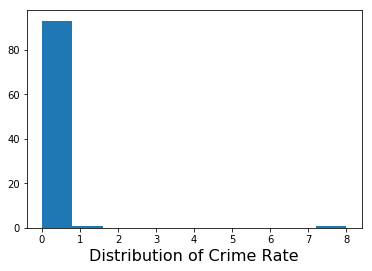

In [8]:
# Crime
plt.hist(df_crime_census['Crime Rate'])
plt.xlabel('Distribution of Crime Rate', fontsize=16)
plt.show()

### There is a clear outlier neighborhood in terms of crime rate. This is the Northwest Industrial District which is a non-residential district. Thus, the low residency rate and highly valuable and secluded property is a breading ground for crime in most majors cities. 

### The crime rate standard deviation given below clearly shows that in most outlier conventions, the Northwest Industrial district is the only outlier which should definitely be removed from our analysis at this point.

In [9]:
np.std(df_crime_census['Crime Rate'])

0.8148314111637383

In [10]:
df_crime_census['Neighborhood'][61]

'NORTHWEST INDUSTRIAL'

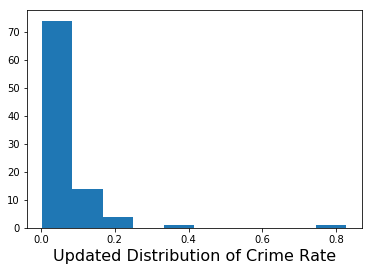

In [11]:
# Removal of Outlier
df_crime_census.drop(df_crime_census.index[61], inplace=True)

# Crime
plt.hist(df_crime_census['Crime Rate'])
plt.xlabel('Updated Distribution of Crime Rate', fontsize=16)
plt.show()

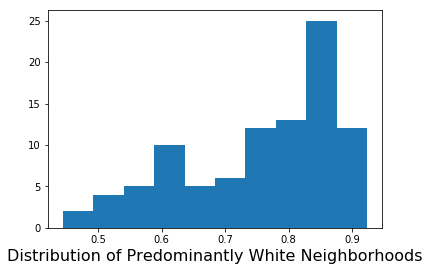

In [12]:
# White Prop
plt.hist(df_crime_census['White Prop'])
plt.xlabel('Distribution of Predominantly White Neighborhoods', fontsize=16)
plt.show()

### As is well-known, Portland is mostly white but the above histogram shows a natural splitting of neighborhoods based on the proporion of white residents. We will call a neighborhood 'Predominantly White' if the proportion of white residents is greater than 0.75. So, we will add a boolean factor to our data frame to help with further exploration and analysis.

### Q: Is there any statistically significant relationship between the proportion of white residents and crime in Portland neighborhoods?

### The histogram below gives a visualization that this splitting of neighborhoods by 'Predominantly White' and 'More Diverse' does not seem to contribute to different crime rates per neighborhood. 

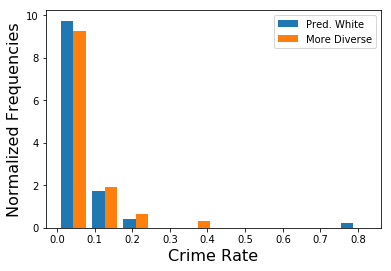

In [13]:
df_crime_census['Predominantly White']=df_crime_census['White Prop']>0.75
df_white=df_crime_census.loc[df_crime_census['Predominantly White']==True]
df_diverse=df_crime_census.loc[df_crime_census['Predominantly White']==False]
plt.xlabel('Crime Rate', fontsize=16)
plt.ylabel('Normalized Frequencies',fontsize=16)
plt.hist([df_white['Crime Rate'],df_diverse['Crime Rate']], density=True)
plt.legend(['Pred. White','More Diverse'])
plt.show()

### Q: Does a higher proportionality of Male residents contribute to higher crime?

### The following scatter plot suggests this question is worth investigation. 

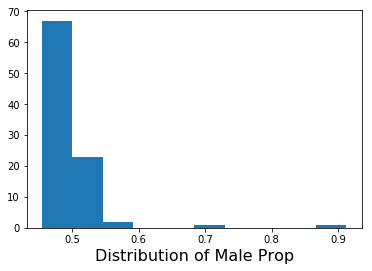

In [14]:
plt.hist(df_crime_census['Male Prop'])
plt.xlabel('Distribution of Male Prop', fontsize=16)
plt.show()

In [15]:
np.std(df_crime_census['Male Prop'])

0.05161390455170787

### As with crime, there is a clear outliers worthy of a closer look.

### As seen by the following percentiles, the Sunderland Neighborhood has a high Single Parent Proportion and a low Owner Occupied Proportion. Combining these with an extremely high Male Proportion, one gets an unstable community with high stress and  lots of testosterone. This is not a good mix.

### Old Town-Chinatown has few single parents but the Owner Occupied Proportion is almost non-existent as Portland neighborhoods go. Again, as an almost entirely business and rental property neighborhood, this is not typical for a Portland neighborhood.

In [16]:
for idx, row in df_crime_census.iterrows():
    if row['Male Prop']>0.6:
        print(row['Neighborhood'])
        print('***********************')
        print('Single Parent Prop Percentile: '+str(stats.percentileofscore(df_crime_census['Single Parent Prop'],row['Single Parent Prop'])))
        print('Owner Occupied Prop Percentile: '+str(stats.percentileofscore(df_crime_census['Owner Occupied Prop'],row['Single Parent Prop'])))
        print('***********************')
        print('***********************')
# Removal of Outlier

OLD TOWN-CHINATOWN
***********************
Single Parent Prop Percentile: 2.127659574468085
Owner Occupied Prop Percentile: 4.25531914893617
***********************
***********************
SUNDERLAND
***********************
Single Parent Prop Percentile: 87.23404255319149
Owner Occupied Prop Percentile: 20.21276595744681
***********************
***********************


In [17]:
df_crime_census['Neighborhood'][62], df_crime_census['Neighborhood'][85]

('OLD TOWN-CHINATOWN', 'SUNDERLAND')

In [18]:
# Drop Outliers
df_crime_census.drop([62,85],inplace=True)

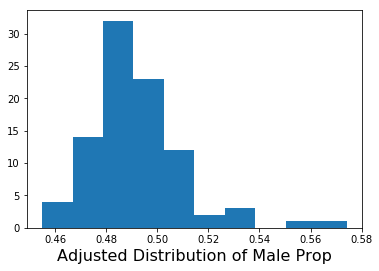

In [19]:
plt.hist(df_crime_census['Male Prop'])
plt.xlabel('Adjusted Distribution of Male Prop', fontsize=16)
plt.show()

### With outliers removed, the scatter plot below suggests a possible positive correlation between crime rate and the proportion of males in the population. This warrents further analysis.

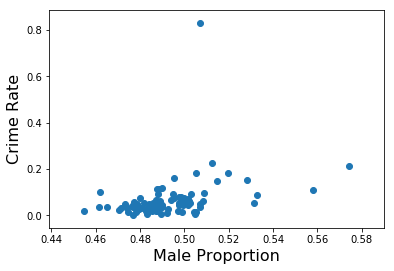

In [20]:
x = list(df_crime_census['Male Prop'])
y = list(df_crime_census['Crime Rate'])
plt.xlabel('Male Proportion', fontsize=16)
plt.ylabel('Crime Rate', fontsize=16)
plt.scatter(x,y)

### Q. Does a higher number of children relate to crime in general?

### The histogram and standard deviation below imply there are no outlier neighborhoods, of those not already removed. 

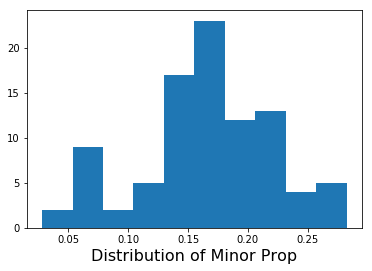

In [21]:
plt.hist(df_crime_census['Minor Prop'])
plt.xlabel('Distribution of Minor Prop', fontsize=16)
plt.show()

In [22]:
np.std(df_crime_census['Minor Prop'])

0.0556884121736941

### The following scatter plot shows a possible negative correlation between crime in general and the proportion of the population that are under 18 years of age. Like the proportion of Males, this warrants a closer look through the eyes of statistical significance.

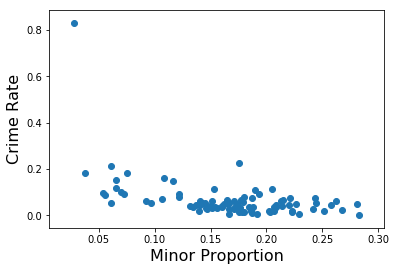

In [23]:
x = list(df_crime_census['Minor Prop'])
plt.xlabel('Minor Proportion', fontsize=16)
plt.ylabel('Crime Rate', fontsize=16)
plt.scatter(x,y)

### Q. Does a higher proportion of owner occupied households relate to crime in general?

### Again, we see that there are no clear outliers due to the below distrubution and standard deviation. As with the prevelance of children, this factor apprears that it may have a negative correlation with crime. This is somewhat intuitive as a higher proportion of owner occupied homes with children provide a more stable set of residents which are highly invested in their neighborhood and its well-being. It also means more economically stable residents with better security, both technologically and socially. Also, a somewhat unfortunate reality is that such neighborhoods in a city generally have faster emergency response.

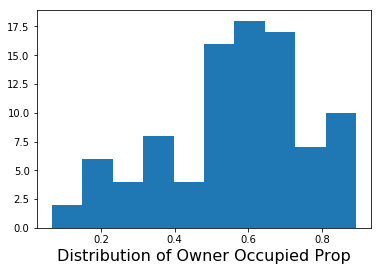

In [24]:
plt.hist(df_crime_census['Owner Occupied Prop'])
plt.xlabel('Distribution of Owner Occupied Prop', fontsize=16)
plt.show()

In [25]:
np.std(df_crime_census['Owner Occupied Prop'])

0.19698915070236428

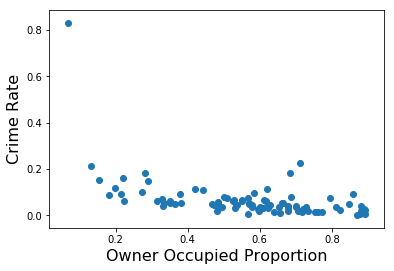

In [26]:
x = list(df_crime_census['Owner Occupied Prop'])
plt.xlabel('Owner Occupied Proportion', fontsize=16)
plt.ylabel('Crime Rate', fontsize=16)
plt.scatter(x,y)

## 2.2. Story Telling Summary

### The initial exploration above suggests that diversity does play a role in the crime rate of a cities neighborhoods. However, the factor of race, which is often tied to economic means appears less important in Portland than other less talked about factors like the prevalence of children, males, and owner occupied homes. 

### Clearly, some formal statistical analysis needs to be done to provide evidence for or against our initial observations. Moreover,  there is a lot more data which may also shed some light on crime in Portland. One which is likely of some importance is geographic area per household. Everyone needs some space and if that is not available, especially for people living in neighborhoods with other risk factors for crime, stress levels will be elevated and could contribute to the increase in crime. 

### Another important factor to be consideres is that of the types of crimes, i.e. violent vs non-violent and general theft and the more subtle crimes involving fraud. These too will be looked at more closely through a statistical lense.